In [42]:
from langgraph.graph import StateGraph,START,END
from langchain_cohere import ChatCohere
from dotenv import load_dotenv
from typing import TypedDict,Literal,Annotated
from langchain_core.messages import SystemMessage,HumanMessage
from operator import add

In [27]:
load_dotenv()
generator_llm=ChatCohere(model="command-r-plus-08-2024")
evaluator_llm=ChatCohere(model="command-r-plus-08-2024")
optimizer_llm=ChatCohere(model="command-r-plus-08-2024")

In [43]:
class PostState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal["Approved","Needs_Improvement"]
    feedback:str
    iteration:int
    max_iterator:int
    
    tweet_history:Annotated[list[str],add]
    feedback_history:Annotated[list[str],add]

In [44]:
def generate_post(state:PostState)->dict:
    
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
            Write a short, original, and hilarious tweet on the topic: "{state["topic"]}".

            Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english.
        """)
    ]
    result=generator_llm.invoke(messages).content

    return {"tweet":result,"tweet_history":[result]}

In [53]:
from pydantic import BaseModel,Field

class EvaluationSchema(BaseModel):
    Evaluation:Literal["Approved","Need_improvement"]=Field(description="Based on the post just repond with Approved or Need_improvement")
    Feedback:str=Field(description="Give a detailed feedback focusing on area of improvement")
    
evaluator_llm_with_structured_output=evaluator_llm.with_structured_output(EvaluationSchema)



def evaluate_post(state:PostState)->dict:
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor,originality, virality, and tweet format."),
        HumanMessage(content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality - Is this fresh, or have you seen it a hundred times before?
            2. Humor - Did it genuinely make you smile, laugh, or chuckle?
            3. Punchiness - Is it short, sharp, and scroll-stopping?
            4. Virality Potential - Would people retweet or share it?
            5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did ... " or "What happens when ... ")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle
            universe" or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs improvement"
            - feedback: One paragraph explaining the strengths and weaknesses
        """)
    ]
    result=evaluator_llm_with_structured_output.invoke(messages)
    return {"evaluation":result.Evaluation,"feedback":result.Feedback,"feedback_history":[result.Feedback]}

In [52]:
def optimize_post(state:PostState)->dict:
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']},

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """)
    ]
    response=optimizer_llm.invoke(messages).content
    iteration=state['iteration']+1
    return {"tweet":response,"iteration":iteration,"tweet_history":[response]}

In [48]:
def check_condition(state:PostState):
    if state["evaluation"]=="Approved" or state["iteration"]>=state["max_iterator"]:
        return "Approved"
    else:
        return "Need_improvement"

In [54]:
graph=StateGraph(PostState)

graph.add_node("generate",generate_post)
graph.add_node("evaluate",evaluate_post)
graph.add_node("optimize",optimize_post)

graph.add_edge(START,"generate")
graph.add_edge("generate","evaluate")
graph.add_conditional_edges("evaluate",check_condition,{"Approved":END,"Need_improvement":"optimize"})

graph.add_edge("optimize","evaluate")

workflow=graph.compile()


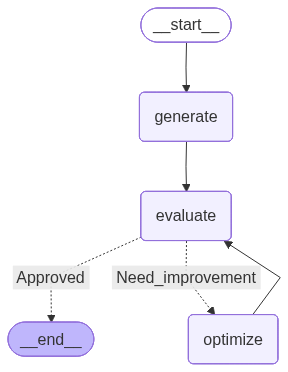

In [55]:
workflow

In [56]:
result=workflow.invoke({"topic":"Nepals Airlines","max_iterator":5,"iteration":1})

In [57]:
result

{'topic': 'Nepals Airlines',
 'tweet': "Just boarded a Nepals Airlines flight and they're offering a unique in-flight experience: a mountain-sized turbulence adventure! 🏔️🛩️ Brace yourself for a bumpy ride, or as they say in Nepal, a 'Himalayan high-five'! #TravelGoals #NepalsAirlines #BumpyRidesAreFun",
 'evaluation': 'Approved',
 'feedback': "This tweet is a creative and humorous take on an in-flight experience, offering a unique perspective on air travel. The play on words with 'Himalayan high-five' is original and could elicit a chuckle from readers, especially those who appreciate puns. It is short and snappy, adhering to the character limit, and the use of emojis adds a playful touch. The tweet has the potential to go viral, as it combines humor with a travel-related topic, which is often popular on social media. Additionally, it is well-structured and avoids the pitfalls of a traditional joke format.",
 'iteration': 1,
 'max_iterator': 5,
 'tweet_history': ["Just boarded a Nepal